In [0]:
###############################################################
#Title: MixMatch: A Holistic Approach to Semi-Supervised Learning
#Author: Berthelot, Carlini, Goodfellow, Oliver, Papernot and Raffel
#Blog: https://towardsdatascience.com/a-fastai-pytorch-implementation-of-mixmatch-314bb30d0f99?
#Date: 2019
#Availability: https://github.com/noachr/MixMatch-fastai
###############################################################

###############################################################
#Title: FastAI Extensions for CutMix and MixUp
#Author: Ignacio Oguiza
#Availability: https://github.com/oguiza/fastai_extensions
###############################################################

from fastai import *
from fastai.vision import *
from sklearn.datasets import make_moons, make_blobs, make_circles, make_classification
import seaborn as sns
import pdb
import contextlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from fastai.torch_core import *
from fastai.callback import *
from fastai.train import mixup
from fastai.callbacks.mixup import MixUpCallback, MixUpLoss
from fastai.basic_train import Learner, LearnerCallback
from fastai.vision.image import Image, TfmPixel

from fastai.core import *

class TimeSeriesItem(ItemBase):
    "`ItemBase` suitable for time series"

    def __init__(self, item, *args, **kwargs):
        super().__init__(item, *args, **kwargs)
        self.data = item
        self.obj = item
        self.channels = item.shape[-2]
        self.seq_len = item.shape[-1]


    def __str__(self):
        return 'TimeSeries(ch={:.0f}, seq_len={:.0f})'.format(
            self.channels, self.seq_len)

    def clone(self):
        return self.__class__(self.data.clone())

    def apply_tfms(self, tfms, **kwargs):
        x = self.clone()
        for tfm in tfms:
            x.data = tfm(x.data)
        return x

    def reconstruct(self, item):
        return TimeSeriesItem(item)

    def show(self, ax=None, title=None, **kwargs):
        if ax is None:
            plt.plot(self.data.transpose_(0, 1))
            plt.show()
        else:
            ax.plot(self.data.transpose_(0, 1))
            ax.title.set_text(title)
            ax.tick_params(
                axis='both',
                which='both',
                bottom='off',
                top='off',
                labelbottom='off',
                right='off',
                left='off',
                labelleft='off')
            return ax


class RicapLoss(nn.Module):
    "Adapt the loss function `crit` to go with ricap data augmentations."

    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'):
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else:
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction

    def forward(self, output, target):
        if target.ndim == 2:
            c_ = target[:, 1:5]
            W_ = target[:, 5:]
            loss = [W_[:, k] * self.crit(output, c_[:, k].long()) for k in range(4)]
            d = torch.mean(torch.stack(loss))
        else: d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum': return d.sum()
        return d

    def get_old(self):
        if hasattr(self, 'old_crit'): return self.old_crit
        elif hasattr(self, 'old_red'):
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

class RicapCallback(LearnerCallback):
    '''Adapted from :
    paper: https://arxiv.org/abs/1811.09030
    github: https://github.com/4uiiurz1/pytorch-ricap
    and mixup in the fastai library.'''
    def __init__(self, learn:Learner, beta:float=.3, stack_y:bool=True):
        super().__init__(learn)
        self.beta,self.stack_y = beta,stack_y

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = RicapLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies ricap to `last_input` and `last_target` if `train`."
        if not train or self.beta == 0: return

        # get the image size
        I_x, I_y = last_input.size()[2:]

        # draw a boundary position (w, h)
        w = int(np.round(I_x * np.random.beta(self.beta, self.beta)))
        h = int(np.round(I_y * np.random.beta(self.beta, self.beta)))
        w_ = [w, I_x - w, w, I_x - w]
        h_ = [h, h, I_y - h, I_y - h]

        # select and crop four images
        cropped_images = {}
        bs = last_input.size(0)
        c_ = torch.zeros((bs, 4)).float().to(last_input.device)
        W_ = torch.zeros(4).float().to(last_input.device)
        for k in range(4):
            idx = torch.randperm(bs).to(last_input.device)
            x_k = np.random.randint(0, I_x - w_[k] + 1)
            y_k = np.random.randint(0, I_y - h_[k] + 1)
            cropped_images[k] = last_input[idx][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
            c_[:, k] = last_target[idx].float()
            W_[k] = w_[k] * h_[k] / (I_x * I_y)

        # patch cropped images
        patched_images = torch.cat(
            (torch.cat((cropped_images[0], cropped_images[1]), 2),
             torch.cat((cropped_images[2], cropped_images[3]), 2)), 3).to(last_input.device)

        # modify last target
        if self.stack_y:
                new_target = torch.cat((last_target[:,None].float(), c_,
                                        W_[None].repeat(last_target.size(0), 1)), dim=1)
        else:
            new_target = c_ * W_

        return {'last_input': patched_images, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def ricap(learn:Learner, beta:float=.3, stack_y:bool=True) -> Learner:
    "Add ricap https://arxiv.org/pdf/1811.09030.pdf to `learn`."
    learn.callback_fns.append(partial(RicapCallback, beta=beta, stack_y=stack_y))
    return learn

setattr(ricap, 'cb_fn', RicapCallback)
Learner.ricap = ricap

setattr(mixup, 'cb_fn', MixUpCallback)


class CutMixCallback(LearnerCallback):
    '''Adapted from :
    paper: https://arxiv.org/abs/1905.04899
    github: https://github.com/clovaai/CutMix-PyTorch
    and mixup in the fastai library.'''

    def __init__(self, learn:Learner, alpha:float=1., stack_y:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_y = alpha,stack_y

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies cutmix to `last_input` and `last_target` if `train`."
        if not train or self.alpha == 0: return
        λ = np.random.beta(self.alpha, self.alpha)
        λ = max(λ, 1- λ)
        bs = last_target.size(0)
        idx = torch.randperm(bs).to(last_input.device)
        x1, y1 = last_input[idx], last_target[idx]

        #Get new input
        last_input_size = last_input.size()
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input_size, λ)
        new_input = last_input.clone()
        new_input[..., bby1:bby2, bbx1:bbx2] = x1[..., bby1:bby2, bbx1:bbx2]
        #λ = last_input.new([λ])
        λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
        λ = last_input.new([λ])

        # modify last target
        if self.stack_y:
            new_target = torch.cat([last_target.unsqueeze(1).float(), y1.unsqueeze(1).float(),
                                    λ.repeat(last_input_size[0]).unsqueeze(1).float()], 1)
        else:
            if len(last_target.shape) == 2:
                λ = λ.unsqueeze(1).float()
            new_target = last_target.float() * λ + y1.float() * (1-λ)

        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''

    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    if len(last_input_size) == 4:
        bby2 = np.clip(cy + cut_h // 2, 0, H)
    else: bby2 = last_input_size[1]

    return bbx1, bby1, bbx2, bby2


def cutmix(learn:Learner, alpha:float=1., stack_x:bool=False, stack_y:bool=True) -> Learner:
    "Add cutmix https://arxiv.org/pdf/1905.04899.pdf to `learn`."
    learn.callback_fns.append(partial(CutMixCallback, alpha=alpha, stack_y=stack_y))
    return learn

setattr(cutmix, 'cb_fn', CutMixCallback)
Learner.cutmix = cutmix


def get_x1_coords(x_size, n_patches, same_size=True):
    if same_size:
        w = np.linspace(0, x_size[-1], num=n_patches[0] + 1).astype(np.int64)
        h = np.linspace(0, x_size[-2], num=n_patches[1] + 1).astype(np.int64)
    else:
        w, h = [], []
        if n_patches[0] > 1:
            w = sorted(list(np.random.choice(np.arange(0, x_size[-1]),
                                             size= n_patches[0] - 1, replace=False)))
        if n_patches[1] > 1:
            h = sorted(list(np.random.choice(np.arange(0, x_size[-2]),
                                             size= n_patches[1] - 1, replace=False)))
        w = [0] + w + [x_size[-1]]
        h = [0] + h + [x_size[-2]]
    patch = []
    for i in range(n_patches[0]):
        for j in range(n_patches[1]):
            patch.append([h[j], h[j + 1], w[i], w[i + 1]])
    return patch


def get_x1_rand_coords(x_size, n_patches, w, h, same_size=True):
    if not same_size:
        a = w * h
        p = np.random.uniform() + .5
        w = max(1, int(p * w))
        h = max(1, int(a / w))
    w_x = np.random.randint(0, x_size[-1]) if n_patches[0] != 1 else 0
    w_xa = np.clip(w_x - w // 2, 0, x_size[-1])
    w_xb = np.clip(w_x + w // 2, 0, x_size[-1])
    h_x = np.random.randint(0, x_size[-2]) if n_patches[1] != 1 else 0
    h_xa = np.clip(h_x - h // 2, 0, x_size[-2])
    h_xb = np.clip(h_x + h // 2, 0, x_size[-2])
    return h_xa, h_xb, w_xa, w_xb


def get_x2_coords(x_size, bby1, bby2, bbx1, bbx2):
    w_ = bbx2 - bbx1
    h_ = bby2 - bby1
    w_k = np.random.randint(0, x_size[-1] - w_) if w_ != x_size[-1] else 0
    h_k = np.random.randint(0, x_size[-2] - h_) if h_ != x_size[-2] else 0
    return h_k, h_k + h_, w_k, w_k + w_


#export

class BlendLoss(nn.Module):
    "Adapt the loss function `crit` to go with blend data augmentations."

    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'):
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else:
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction

    def forward(self, output, target):
        if target.ndim == 2:# and target.shape[-1] >1:
            n_mod_patches = (target.shape[-1] - 1) // 2
            c_ = target[:, 1:n_mod_patches + 1]
            W_ = target[:, n_mod_patches + 1:]
            loss = [W_[:, k] * self.crit(output, c_[:, k].long()) for k in range(n_mod_patches)]
            d = torch.mean(torch.stack(loss))
        else: d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum': return d.sum()
        return d

    def get_old(self):
        if hasattr(self, 'old_crit'): return self.old_crit
        elif hasattr(self, 'old_red'):
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit


class BlendCallback(LearnerCallback):
    "Callback that creates the blend input and target."
    def __init__(self, learn:Learner,
                 size:tuple=(.1, .1), alpha:float=1., fixed_proba:float=0.,
                 blend_type:str='cut', grid:bool=True,
                 same_size:bool=True, same_crop:bool=True, same_image:bool=False):
        ''' Modifies one or multiple subregions of an image
        Parameters:
        size:
            int tuple(height pixels, wide pixels), float tuple (height % img, wide % img)
            int (pixels) or float (percent_tuple)
            None full image
        alpha: proba that each patch is modified from np.random.beta(alpha, alpha)
        fixed_proba: proba that each individual patch is modified. If >0 overrides alpha.
        blend_type: 'zero', 'noise', 'mix', 'cut' or 'rand'(any of the previous)
        grid: True - a grid is applied to the image so that patches never overlap (required in 'mix' and 'cut')
        same_size: True - all patches will have approx the same size, otherwise random
        same_crop: cropping subregion will be the same as input subregion, otherwise different
        same_image: False - cropping image will be different from input image, otherwise same
        '''
        assert blend_type in ['zero', 'noise', 'mix', 'cut', 'random'], \
        print("make sure you select one of these blend_types: 'zero', 'noise', 'mix', 'cut', 'random'")
        if not grid and not same_image:
            assert blend_type in ['zero', 'noise'],\
            print('either grid or same_image must be set to True when using', blend_type)
        super().__init__(learn)
        self.size,self.alpha,self.fixed_proba,self.blend_type = size,alpha,fixed_proba,blend_type
        self.grid,self.same_size,self.same_crop,self.same_image = grid,same_size,same_crop,same_image

    def on_train_begin(self, **kwargs):
        if not self.same_image: self.learn.loss_func = BlendLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies blend to `last_input` and `last_target` if `train`."
        if not train: return {'last_input': last_input, 'last_target': last_target}
        if self.alpha == 0 and self.fixed_proba == 0:
            return {'last_input': last_input, 'last_target': last_target}

        x_size = last_input.size()
        bs = x_size[0] # batch size
        i_h, i_w = x_size[2:] # image height, width
        if not isinstance(self.size, tuple): self.size = (self.size, self.size)
        p_h, p_w = self.size # patch percent height, width
        if p_h == 1 or isinstance(p_h, float): h = int(p_h * i_h) # patch height in pixels
        else: h = p_h
        if p_w == 1 or isinstance(p_w, float): w = int(p_w * i_w) # patch width in pixels
        else: w = p_w
        if w == 0 or h == 0: return {'last_input': last_input, 'last_target': last_target}
        patched_images = last_input.clone()

        # patches that will be modified
        n_patches = (i_h // h, i_w // w)
        patch_len = n_patches[0] * n_patches[1]
        patches = get_x1_coords(x_size, n_patches, same_size=self.same_size)
        if self.fixed_proba != 0:
            lambd = self.fixed_proba
        else:
            lambd = np.random.beta(self.alpha, self.alpha)
            lambd = max(lambd, 1- lambd)
        if patch_len == 1: patch_ids = [0]
        elif self.fixed_proba != 0:
            patch_ids = np.arange(patch_len)[np.random.rand(patch_len) <= lambd]
        else:
            patch_ids = np.random.choice(np.arange(patch_len), int(patch_len * (1 - lambd)), replace=False)
        n_mod_patches = len(patch_ids)
        if n_mod_patches == 0: return {'last_input': last_input, 'last_target': last_target}
        #mod_patches = [patches[i] for i in patch_ids]
        c_ = torch.zeros((bs, n_mod_patches)).float().to(last_input.device) # patch labels
        W_ = torch.zeros(n_mod_patches).float().to(last_input.device) # new weights
        idx = torch.linspace(0, bs - 1, steps=bs).to(dtype=torch.int64, device=last_input.device)
        if self.blend_type.lower() == 'random': _blend = np.random.choice(['zero', 'noise', 'mix', 'cut'])
        else: _blend = self.blend_type.lower()
        for i,j in enumerate(patch_ids):
            #x1 coordinates
            if self.grid: bby1, bby2, bbx1, bbx2 = patches[j]
            else: bby1, bby2, bbx1, bbx2 = get_x1_rand_coords(x_size, n_patches, w, h,
                                                              same_size=self.same_size)
            # Blend
            if _blend == 'zero': patched_images[..., bby1:bby2, bbx1:bbx2] = 0
            if _blend == 'noise':
                noise = last_input.new(np.random.rand(bby2 - bby1, bbx2 - bbx1))
                patched_images[..., bby1:bby2, bbx1:bbx2] = noise
            else:
                if not self.same_image: idx = torch.randperm(bs).to(last_input.device)
                #x2 coordinates
                if self.same_crop:
                    x2 = last_input[idx][..., bby1:bby2, bbx1:bbx2]
                else:
                    ccy1, ccy2, ccx1, ccx2 = get_x2_coords(x_size, bby1, bby2, bbx1, bbx2)
                    x2 = last_input[idx][..., ccy1:ccy2, ccx1:ccx2]
                if _blend == 'mix':
                    x1 = last_input[..., bby1:bby2, bbx1:bbx2]
                    if self.size == (1, 1):
                        patched_images[..., bby1:bby2, bbx1:bbx2] = x1 * lambd + x2 * (1 - lambd)
                    else: patched_images[..., bby1:bby2, bbx1:bbx2] = x1 * .5 + x2 * .5
                if _blend == 'cut':
                    patched_images[..., bby1:bby2, bbx1:bbx2] = x2
            W_[i] = (bby2 - bby1) * (bbx2 - bbx1) / (i_w * i_h)
            c_[:, i] = last_target[idx].float()
        # modify last target
        if not self.same_image and n_mod_patches > 0:
            new_target = torch.cat((last_target[:,None].float(), c_, W_[None].repeat(bs, 1)), dim=1)
        else: new_target = last_target
        return {'last_input': patched_images, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if not self.same_image: self.learn.loss_func = self.learn.loss_func.get_old()


def blend(learn:Learner, size:tuple=(.1, .1), alpha:float=1., fixed_proba:float=0.,
                 blend_type:str='cut', grid:bool=True,
                 same_size:bool=True, same_crop:bool=True, same_image:bool=False) -> Learner:
    learn.callback_fns.append(partial(BlendCallback, size=size, alpha=alpha,
                                      fixed_proba=fixed_proba, blend_type=blend_type, grid=grid,
                                      same_size=same_size, same_crop=same_crop, same_image=same_image))
    return learn

setattr(blend, 'cb_fn', BlendCallback)
Learner.blend = blend


import math

class TfmScheduler(LearnerCallback):

    def __init__(self,
                 learn: Learner,
                 tfm_fn: Callable,
                 sch_param: Union[str, StrList],
                 sch_val: Union[StartOptEnd, List],
                 sch_iter: Optional[StartOptEnd] = None,
                 sch_func: Optional[AnnealFunc] = None,
                 plot: bool = False,
                 test: bool = False,
                 **kwargs: Any):

        super().__init__(learn)
        self.learn = learn
        self.batches = math.ceil(len(learn.data.train_ds)/learn.data.train_dl.batch_size)
        sch_param = listify(sch_param)
        if isinstance(sch_param, (float, int)): sch_val = (0, sch_val)
        sch_val = tuplify(sch_val)
        if len(sch_param) != len(sch_val): sch_val = sch_val * len(sch_param)
        assert len(sch_param) == len(sch_val)
        if sch_iter is None: sch_iter = (0., 1.)
        sch_iter = tuplify(sch_iter)
        if len(sch_param) != len(sch_iter): sch_iter = sch_iter * len(sch_param)
        assert len(sch_param) == len(sch_iter)
        self.tfm_fn,self.sch_param,self.sch_val,self.sch_iter,self.test = tfm_fn,sch_param,sch_val,sch_iter,test
        if sch_func is None: sch_func = annealing_linear
        sch_func = listify(sch_func)
        if len(sch_param) != len(sch_func): sch_func = sch_func * len(sch_param)
        assert len(sch_param) == len(sch_func)
        self.sch_func = sch_func
        self.plot = plot
        if not isinstance(self.tfm_fn, functools.partial): self.tfm_fn = partial(self.tfm_fn)
        self.fn = get_fn(self.tfm_fn)
        if hasattr(self.fn, 'cb_fn'): self.fn = self.fn.cb_fn
        if hasattr(self.fn, 'on_batch_begin'): self.cb = True
        else: self.cb = False


    def on_train_begin(self, n_epochs: int, epoch: int, **kwargs: Any):
        if self.cb: self.fn(self.learn).on_train_begin()
        total_iters = n_epochs * self.batches
        self.scheduler = [None] * len(self.sch_param)
        for i in range(len(self.sch_param)):
            p = self.sch_param[i]
            v = self.sch_val[i]
            iters = self.sch_iter[i]
            func = self.sch_func[i]
            self.scheduler[i] = MyScheduler(total_iters, v, sch_iter=iters, sch_func=func)
            s = self.scheduler[i]
            a = s.start_val
            a_ = []
            first_iter = -1
            last_iter = 1
            for i in range(total_iters):
                a = s.step()
                if i > 0 and first_iter == -1 and a != a_[-1]: first_iter = (i - 1) / total_iters
                elif first_iter != -1 and last_iter == 1 and a == a_[-1]: last_iter = i / total_iters
                a_.append(a)
            s.restart()
            text = '{} between {} and {} in iters {:.2f} to {:.2f}'.format(
                p, round(min(a_), 5), round(max(a_), 5), first_iter, last_iter)
            print('\n',text)
            if self.plot:
                plt.plot(a_)
                plt.title(text)
                plt.show()

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if self.test: return {'stop_epoch': True, 'stop_training': True, 'skip_validate': True}
        if train:
            for i, (p, v) in enumerate(zip(self.sch_param, self.sch_val)):
                new_v = self.scheduler[i].step()
                self.tfm_fn.keywords[p] = new_v
            kw = self.tfm_fn.keywords
            if self.cb:
                return self.fn(self.learn, **kw).on_batch_begin(
                    last_input=last_input,last_target=last_target,train=train)
            else:
                new_input = self.fn(last_input, **kw)
                return {'last_input': new_input, 'last_target': last_target}
        else: return

    def on_train_end(self, **kwargs):
        if self.cb: self.fn(self.learn).on_train_end()


class MyScheduler():
    "Used to \"step\" from start,end (`vals`) over `n_iter` iterations on a schedule defined by `func`"
    def __init__(self, total_iters:int, sch_val:StartOptEnd, sch_iter:Optional[StartOptEnd]=None,
                 sch_func:Optional[AnnealFunc]=None):
        self.total_iters = total_iters
        self.start_val,self.end_val = (sch_val[0],sch_val[1]) if is_tuple(sch_val) else (0, sch_val)
        if sch_iter is None: self.start_iter,self.end_iter = (0, total_iters)
        else:
            self.start_iter,self.end_iter = (sch_iter[0],sch_iter[1]) if is_tuple(sch_iter) else (0, sch_iter)
            if self.start_iter == 1 or isinstance(self.start_iter, float):
                self.start_iter = int(self.start_iter * total_iters)
            if self.end_iter == 1 or isinstance(self.end_iter, float):
                self.end_iter = int(self.end_iter * total_iters)
        self.eff_iters = self.end_iter - self.start_iter
        if sch_func is None: self.sch_func = annealing_linear
        else: self.sch_func = sch_func
        self.n = 0

    def restart(self): self.n = 0

    def step(self)->Number:
        "Return next value along annealed schedule."
        self.eff_n = min(max(0, self.n - self.start_iter), self.eff_iters)
        out = self.sch_func(self.start_val, self.end_val, min(1, self.eff_n/(self.eff_iters - 1)))
        self.n += 1
        return out


def cosine_annealing(start:Number, end:Number, pct:float, pct_start=.3, **kwargs)->Number:
    "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    if pct <= pct_start:
        return annealing_cos(start, end, pct/pct_start)
    else:
        return annealing_cos(end, start, (pct - pct_start)/(1 - pct_start))

def inv_annealing_poly(start:Number, end:Number, pct:float, degree:Number, **kwargs)->Number:
    "Helper function for `inv_anneal_poly`."
    return start + (end - start) * (pct)**degree

def inv_annealing_cos(start:Number, end:Number, pct:float, **kwargs)->Number:
    "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    cos_out = np.cos(np.pi * pct) + 1
    return start + (end - start)/2 * cos_out

def tuplify(a):
    if not isinstance(a, list): a = [a]
    for i, x in enumerate(a):
        if not isinstance(x, tuple): a[i] = (0, x)
    return a

def get_fn(a):
    while True:
        if hasattr(a, 'func'): a = a.func
        else: break
    return a



def show_multi_img_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    xb, yb = learn.data.one_batch()
    tfms = learn.data.train_ds.tfms
    for i in range(len(xb)):
        xb[i] = Image(xb[i]).apply_tfms(tfms).data
    for cb in learn.callback_fns:
        try:
            cb_fn = partial(cb.func, **cb.keywords)
            [Image(cb_fn(learn).on_batch_begin(
                        xb, yb, True)['last_input'][0]).show(ax=ax)
                for i, ax in enumerate(
                    plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
            plt.show()
            break
        except:
            plt.close('all')
    return learn


Learner.show_multi_img_tfms = show_multi_img_tfms


def show_single_img_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    img = learn.data.train_ds.x
    tfms = learn.data.train_ds.tfms
    rand_int = np.random.randint(len(img))
    [img[rand_int].apply_tfms(tfms).show(ax=ax) for i, ax in enumerate(
            plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
    plt.show()
    return learn

def show_multi_img_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    xb, yb = learn.data.one_batch()
    tfms = learn.data.train_ds.tfms
    for i in range(len(xb)):
        xb[i] = Image(xb[i]).apply_tfms(tfms).data
    for cb in learn.callback_fns:
        try:
            cb_fn = partial(cb.func, **cb.keywords)
            [Image(cb_fn(learn).on_batch_begin(
                        xb, yb, True)['last_input'][0]).show(ax=ax)
                for i, ax in enumerate(
                    plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
            plt.show()
            break
        except:
            plt.close('all')
    return learn

def show_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    xb, yb = learn.data.one_batch()
    rand_int = np.random.randint(len(xb))
    ndim = xb.ndim
    tfms = learn.data.train_ds.tfms

    if ndim == 4:
        rand_item = Image(xb[rand_int])
        for i in range(len(xb)): xb[i] = Image(xb[i]).apply_tfms(tfms).data
        cb_tfms = 0
        for cb in learn.callback_fns:
            if hasattr(cb, 'keywords') and hasattr(get_fn(cb), 'on_batch_begin'):
                cb_fn = partial(get_fn(cb), **cb.keywords)
                try:
                    fig = plt.subplots(rows, cols, figsize=figsize, sharex=True, sharey=True)[1].flatten()
                    plt.suptitle(get_fn(cb).__name__, size=14)
                    [Image(cb_fn(learn).on_batch_begin(xb, yb, True)['last_input'][0]).show(ax=ax)
                        for i, ax in enumerate(fig)]
                    plt.show()
                    cb_tfms += 1
                    break
                except:
                    plt.close('all')

    elif ndim == 3:
        rand_item = TimeSeriesItem(xb[rand_int])
        cb_tfms = 0
        for cb in learn.callback_fns:
            if hasattr(cb, 'keywords') and hasattr(get_fn(cb), 'on_batch_begin'):
                cb_fn = partial(get_fn(cb), **cb.keywords)
                try:
                    fig = plt.subplots(rows, cols, figsize=figsize, sharex=True, sharey=True)[1].flatten()
                    plt.suptitle(get_fn(cb).__name__, size=14)
                    [TimeSeriesItem(cb_fn(learn).on_batch_begin(xb, yb, True)['last_input'][0]).show(ax=ax)
                        for i, ax in enumerate(fig)]
                    plt.show()
                    cb_tfms += 1
                    break
                except:
                    plt.close('all')

    if cb_tfms == 0:
        if tfms is not None:
            t_ = []
            for t in learn.data.train_ds.tfms: t_.append(get_fn(t).__name__)
            title = f"{str(t_)[1:-1]} transforms applied"
            fig = plt.subplots(rows, cols, figsize=figsize, sharex=True, sharey=True)[1].flatten()
            [rand_item.apply_tfms(tfms).show(ax=ax) for i, ax in enumerate(fig)]
            plt.suptitle(title, size=14)
            plt.show()
        else:
            print('No transformation has been applied')
            rand_item.show()

    return learn

Learner.show_tfms = show_tfms
Learner.show_multi_img_tfms = show_multi_img_tfms
Learner.show_single_img_tfms = show_single_img_tfms

In [0]:
size=24
bs = 64
path = untar_data(URLs.CIFAR); path

PosixPath('/root/.fastai/data/cifar10')

In [0]:
tfms = get_transforms()
data = (ImageList.from_folder(path)
        .split_by_folder(train='train',valid='test')
        .label_from_folder()
        .transform(tfms=tfms, size=size) # <-- single-image transforms
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1)))

path.ls()

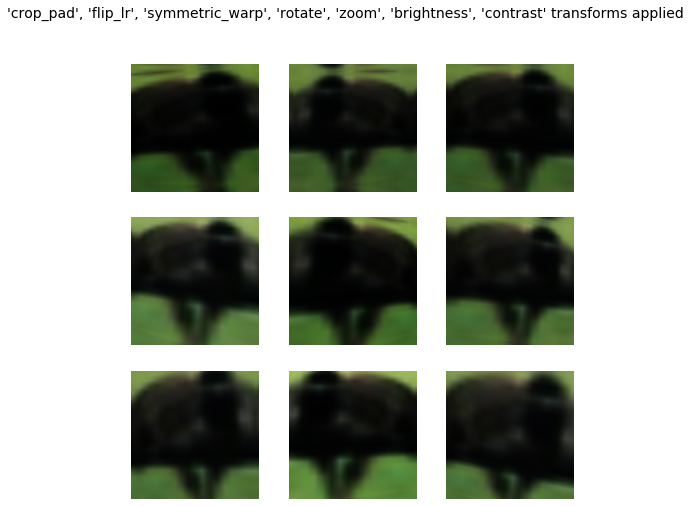

In [0]:
learn = Learner(data, models.resnet34(), loss_func = entropy_min_loss, metrics = accuracy).show_tfms()


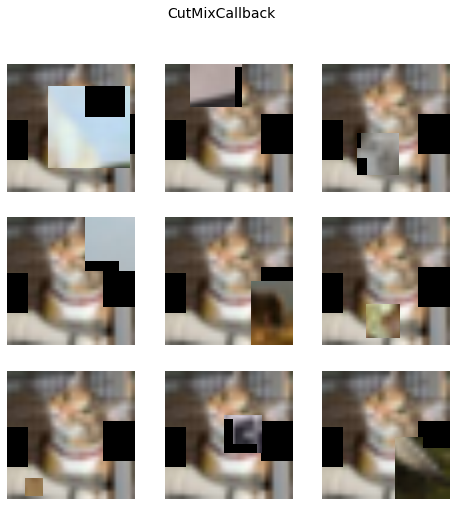

In [0]:

#learn.data.train_ds.tfms = [cutout()]
#learn.cutmix()
learn = Learner(data, models.resnet34(), loss_func = entropy_min_loss , metrics = error_rate).cutmix().show_tfms()
def sharpen(p,T=0.5):
    u = p ** (1/T)
    return u / u.sum(dim=1,keepdim=True)

In [0]:
learn.fit_one_cycle(5)


epoch,train_loss,valid_loss,error_rate,time
0,1.983061,1.981759,0.676500,01:21
1,1.815007,1.669406,0.580300,01:21
2,1.673240,1.301899,0.468900,01:21
3,1.553604,0.940169,0.309300,01:21
4,1.401726,0.806530,0.271400,01:21


In [0]:
class EntropyMinTrainer(LearnerCallback):
    def __init__(self, learn, T=0.5):
        super().__init__(learn)
        self.T = T
        
    def on_train_begin(self, **kwargs):
        self.l_dl = iter(data.train_dl)
        self.it = 0
        
    def on_batch_begin(self, train, last_input, **kwargs):
        if not train: return 
        with torch.no_grad():
            ul_labels = sharpen(torch.softmax(self.learn.model(last_input),dim=1),T=self.T)
            #ul_labels = torch.softmax(self.learn.model(*last_input),dim=1)
        
        self.it += 1
        ramp = self.it / 800.0 if self.it < 800 else 1.0
        return {"last_target": (ul_labels,ramp)}
    
    def on_backward_begin(self, last_loss, last_output, **kwargs):
        try:
            l_x,l_y = next(self.l_dl)
        except:
            self.l_dl = iter(data.train_dl)
            l_x,l_y = next(self.l_dl)
            
        real_preds = self.learn.model(l_x)
        real_loss = F.cross_entropy(real_preds,l_y)
        return {"last_loss": last_loss + real_loss}
    
def entropy_min_loss(preds,target,ramp=None):
    if ramp is None:
        return F.cross_entropy(preds,target)
    preds = torch.softmax(preds,dim=1)
    return 10.0 * ramp * F.mse_loss(preds,target)
    #p = torch.softmax(preds,dim=1)
    #return -(p * torch.log(p)).sum(dim=1).mean()
    #d = torch.distributions.Categorical(torch.softmax(preds,dim=1))
    #return d.entropy().mean()


class BasicNN(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,64,3,2,1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,128,3,2,1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128))
        self.out = nn.Linear(128,num_classes)
        
    def forward(self, x, noise=True):
        x = self.conv(x)
        x = F.adaptive_avg_pool2d(x,1).view(-1,128)
        return self.out(x)

In [0]:
learn = Learner(data,BasicNN,loss_func=entropy_min_loss,callback_fns=[partial(EntropyMinTrainer,T=1.0)],metrics=accuracy)

In [0]:
learn.fit_one_cycle(100,3e-3,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.000000,1.696293,0.388800,00:59
1,0.000000,1.553462,0.454600,00:59
2,0.000000,1.454727,0.479700,01:00
3,0.000000,1.380092,0.502400,01:00
4,0.000000,1.321531,0.529100,01:00
5,0.000000,1.278534,0.541900,01:00
6,0.000000,1.260383,0.549100,01:00
7,0.000000,1.258792,0.549900,01:01
8,0.000000,1.191337,0.577600,01:00
9,0.000000,1.172325,0.587900,01:00


In [0]:
digits, preds, pred_labels, labels = [], [], [], []
l = torch.eye(10).byte().cuda()
learn.model.eval()
with torch.no_grad():
    for x,y in progress_bar(iter(dataFull.valid_dl),total=len(dataFull.valid_dl)):
        p = learn.model(x).detach()
        p = torch.softmax(p,dim=1)
        p_a = torch.argmax(p,dim=1)
        preds.append(p.masked_select(l[p_a]))
        pred_labels.append(p_a)
        labels.append(y)
        digits.append(x[:,0].view(-1,32*32))

labels = torch.cat(labels)
digits = torch.cat(digits)
preds = torch.cat(preds)
pred_labels = torch.cat(pred_labels)
(pred_labels == labels).float().mean()